<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

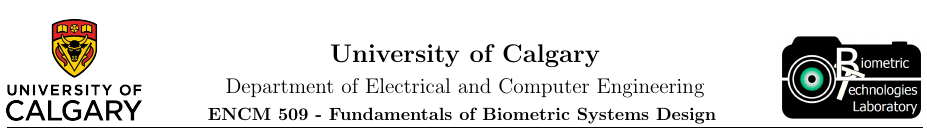

<center>
    <h1>Laboratory Experiment #4</h1>
    <h2>PCA and Threshold-based matching</h2>
</center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import exposure
import scipy.linalg as la

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

%matplotlib inline

In [2]:
# You can specify you directory here, please, change the string below:
path = './ATT dataset/s1/'

#### Number of images in your training set.

In [3]:
# M could be large (for example, 16: 8 of yours and 8 of a friend)
# for At&T dataset there are 10 faces per subject. 
# However, we are going to load only the first 9
# the 10th image will be used to compare later on.
M = 9

#### Image normalization:  

In [4]:
# can be any number that is close to the std and mean of most of the images.
um = 100
ustd = 80

Reading and showing the images

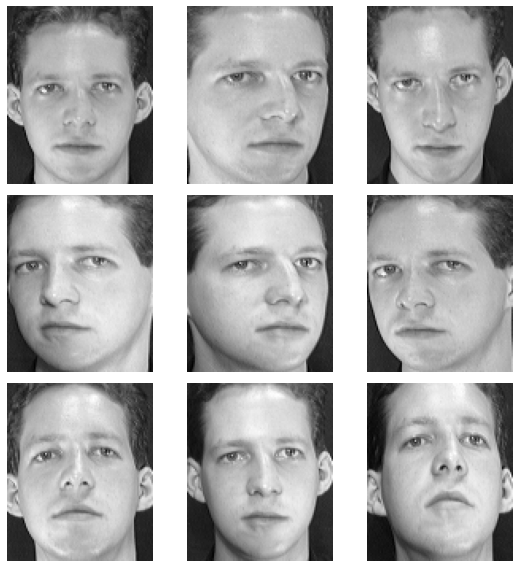

In [5]:
# loading only one image to get the dimensions
# you can use images .jpg and .ng as well
img = imread(path + '1.pgm', as_gray=True)

# get the number of rows (irow) and columns (icol). 
# these values must to be the same for all images
irow, icol = img.shape

# allocation of vector that will have all images
S = np.zeros((irow*icol, M)) # img matrix

plt.figure(figsize=(8,8))
for i in range(1,M+1):
    img = imread(path + '{}.pgm'.format(i), as_gray=True)
    
    plt.subplot(3,3,i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    # reshape(img',irow*icol,1); 
    # creates a (N1*N2)x1 vector
    temp = np.reshape(img, (irow*icol,1))
    S[:,i-1] = temp[:,0] 
# after finishing the sequence, S is a N1*N2xM matrix 

Here we **normalize** all images by changing the *mean* and *std* of each one. This is done to reduce the error due to lighting conditions and background.

In [6]:
# looping over all the loaded images in S to normalize
for i in range(S.shape[1]):
    temp = S[:,i]
    m = np.mean(temp)
    st = np.std(temp)
    # calculation where are defined the new pixels intensities
    S[:,i] = (temp - m) * ustd / st + um

### Normalized images

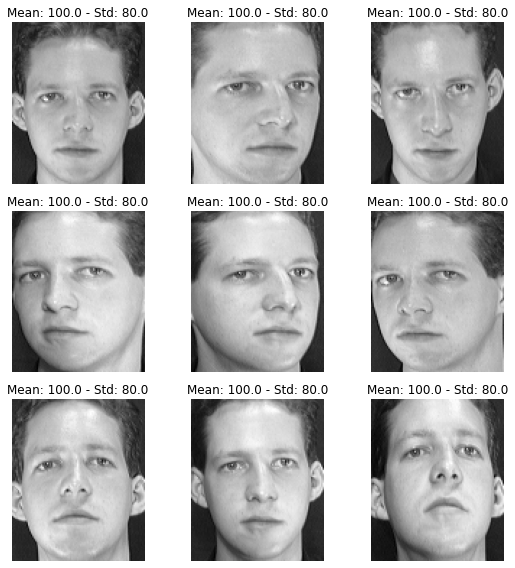

In [7]:
plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(S[:,i], (irow, icol))
    
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Mean: %.1f - Std: %.1f' % (np.mean(img), np.std(img)))

#### Mean image

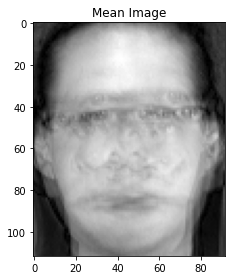

In [8]:
# calculates the mean of each row instead of each column
m = np.mean(S, axis=1)
# converts to unsigned 8-bit integer. Values range from 0 to 255
m = np.uint8(np.abs(m)).reshape(-1,1) 

img = np.reshape(m, (irow, icol))
plt.imshow(img, cmap='gray')
plt.title('Mean Image');

#### Creating covariance matrix  L

In [9]:
dbx = S.copy()
A = dbx.T
L = np.matmul(A, A.T)

# vv is the eigenvector for L
# dd is the eigenvalue for  L = dbx.T*dbx
dd, vv = la.eig(L)

#### Sort and eliminate zero eigenvalue

In [10]:
v = np.zeros(vv.shape)
d = np.zeros(dd.shape)

for i in range(vv.shape[1]):
    if (dd[i] > 1e-4):
        v[:,i] = vv[:,i]
        d[i] = dd[i]
        
# sort d in ascending order
index = np.argsort(d)
B = d[index]
ind = np.zeros(index.shape).astype(int)
dtemp = np.zeros(index.shape)
vtemp = np.zeros(v.shape)

idx_len = len(index)
for i in range(idx_len):
    dtemp[i] = B[idx_len-1-i]
    ind[i] = idx_len-1-index[i]
    vtemp[:,ind[i]] = v[:,i]

d = dtemp
v = vtemp

<ipython-input-10-99f1d61e62f7>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i] = dd[i]


#### Normalization of eigenvectors

In [11]:
for i in range(v.shape[1]):
    kk = v[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    v[:,i] = v[:,i] / temp
    
# Eigenvectors of C matrix
u = np.zeros(dbx.shape)
for i in range(v.shape[1]):
    temp = np.sqrt(d[i])
    u[:,i] = np.matmul(dbx, v[:,i]) / temp
    
for i in range(u.shape[1]):
    kk = u[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    u[:,i] = u[:,i] / temp

#### Showing eigenfaces

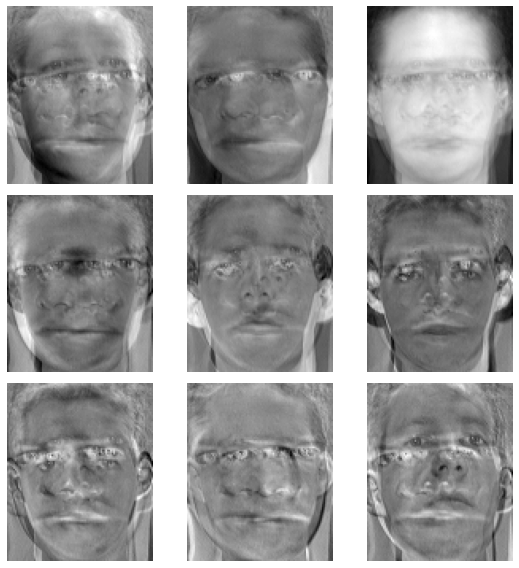

In [12]:
plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(u[:,i], (irow, icol))
    
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

#### Find the weight of each face in the training set

In [13]:
omega = np.zeros((M,M))
WW = np.zeros((M,1))

for h in range(dbx.shape[1]):
    for i in range(u.shape[1]):
        t = u[:,i].T
        WeightOfImage = np.dot(t, dbx[:,h].T)
        WW[i] = WeightOfImage
    omega[:,h] = WW[:,0]

## Acquisition of new image: Same subject
*Notes*: 
- The input image must have a bmp, jpg or pgm extension. 
- It should have the same size as the ones in your training set. 

In [14]:
# using the last image of subject #1
path = './ATT dataset/s1/'
InputImage = imread(path + '10.pgm', as_gray=True)

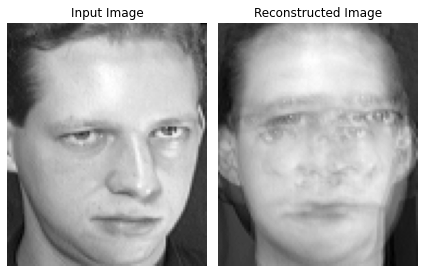

In [15]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference: NormalizedImage - MeanImage
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

#### Finding the Euclidean distance

In [16]:
eSameSubject = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eSameSubject[i] = mag

# max/min Euclidean distance
MaximumValue = np.max(eSameSubject) 
MinimumValue = np.min(eSameSubject) 

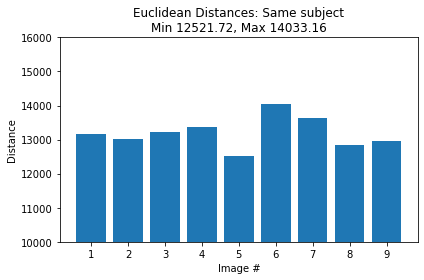

In [17]:
labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eSameSubject)), eSameSubject.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Same subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

## Acquisition of new image: Other subject
*Notes*: 
- The input image must have a bmp, jpg or pgm extension. 
- It should have the same size as the ones in your training set. 

In [18]:
# using the first face ('1.pgm') from subject 20
path = './ATT dataset/s20/'
InputImage = imread(path + '1.pgm', as_gray=True)

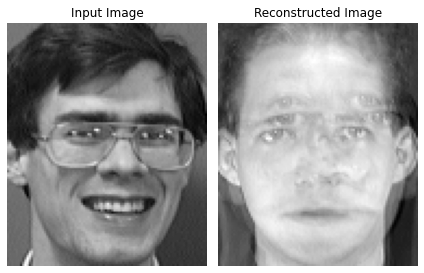

In [19]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

### Finding the Euclidean distance

In [20]:
eDiffSubject = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eDiffSubject[i] = mag
    
# max/min Eucledian distance
MaximumValue = np.max(eDiffSubject) 
MinimumValue = np.min(eDiffSubject) 

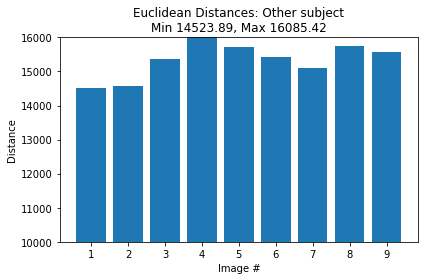

In [21]:
labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eDiffSubject)), eDiffSubject.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Other subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

## Acquisition of new image: Not Human Face
*Notes*: 
- The input image must have a bmp, jpg or pgm extension. 
- It should have the same size as the ones in your training set. 

In [22]:
# using the first face ('1.pgm') from subject 20
path = './'
InputImage = imread(path + 'CalgaryTower.jpg', as_gray=True)

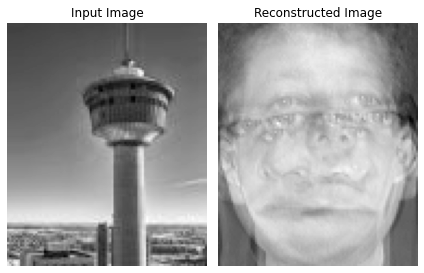

In [23]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

### Finding the Euclidean distance

In [24]:
eTower = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eTower[i] = mag
    
# max/min Eucledian distance
MaximumValue = np.max(eTower) 
MinimumValue = np.min(eTower) 

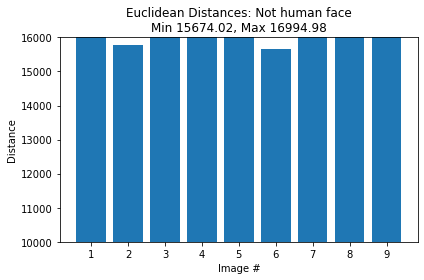

In [25]:
labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eTower)), eTower.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Not human face\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

#### Change and uncomment the fragment below using your Threshold values to classify the face as "Match", "non-Match", or "Not-a-face"

In [26]:
# Set Threshold Values 
threshold1 = 14000
threshold2 = 15500

distances = eSameSubject
#distances = eDiffSubject
#distances = eTower


mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Image is in the database')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face')

Image is in the database


## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
2. (10 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. Conclusion (a paragraph on what is the main take-out of the lab).

- **Exercise 1** (4 marks): For this exercise, you are going to build a gallery and perform the classification (matching) for the three cases (face known to the gallery, face unknown to the gallery and not a face, as shown in Fig. 2 of Lab 4 handout. However, you need to choose  two or three different subjects (for example, subjects 2, 3 and 4)  from the dataset, or create your own dataset. Use the first 9 images of each subject to build the gallery dataset. For example, if you choose 3 subjects, then you have a gallery of 3 x 9 = 27 faces, and for algorithm each  image is a sample, or input (no separate model is built per subject).

Now, choose the probe images as follows: 1) the 10th image of each of the three  subjects  in the dataset; 2) 2-3  faces of the subjects not known to the dataset (could be yours, if you wish); 3) 1-2 not-a-face image. For each of the  comparisons, save the Euclidean distances calculated and annotate the minimum and maximum value in each case. 

- **Exercise 2** (3 marks): Determine the first and the second thresholds; hint: analyze the   maximum of the Euclidean distances  for the probe images known to the dataset. 

To find the second threshold, use unknown faces as the input faces and gather all the  Euclidean distance. Hint: consider the maximum as the second threshold, but also analyze other values.

- **Exercise 3** (3 marks): Extend the Lab's Jupyter notebook (`FaceRec.ipynb`), so that it can calculate the thresholds as investigated above in Exercise 2, and provide the decision output: 'Face is known to the dataset, subject 2', 'Face is unknown to the dataset', or 'Not-a-face'.

Draw conclusions and make suggestions on the procedure improvement.

## Lab 04 (ENCM 509) Group 24

Group Members:
Roszell, Jeffrey
San Juan, John
Wood, Oliver

February 11 2021

### Introduction

In this lab we will be exploring face recognition using principle component analysis and threshold testing. We will be building a database of a few eigenfaces through some training algorithms. We will then test the model on faces which belong, those that have not been trained, and a completely irrelevant photo. We will then calculate the eucladian distances, and decide on what is appropriate threhold limits in ordr for accurate matching rates. Based on these values we will give the end results a rating of 'Face is known','Face is unknown', or 'Not a face'.

### Exercise 1

#### Building Gallery Dataset:
Subjects to be used: S6, S16, and S26

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import exposure
import scipy.linalg as la

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

%matplotlib inline

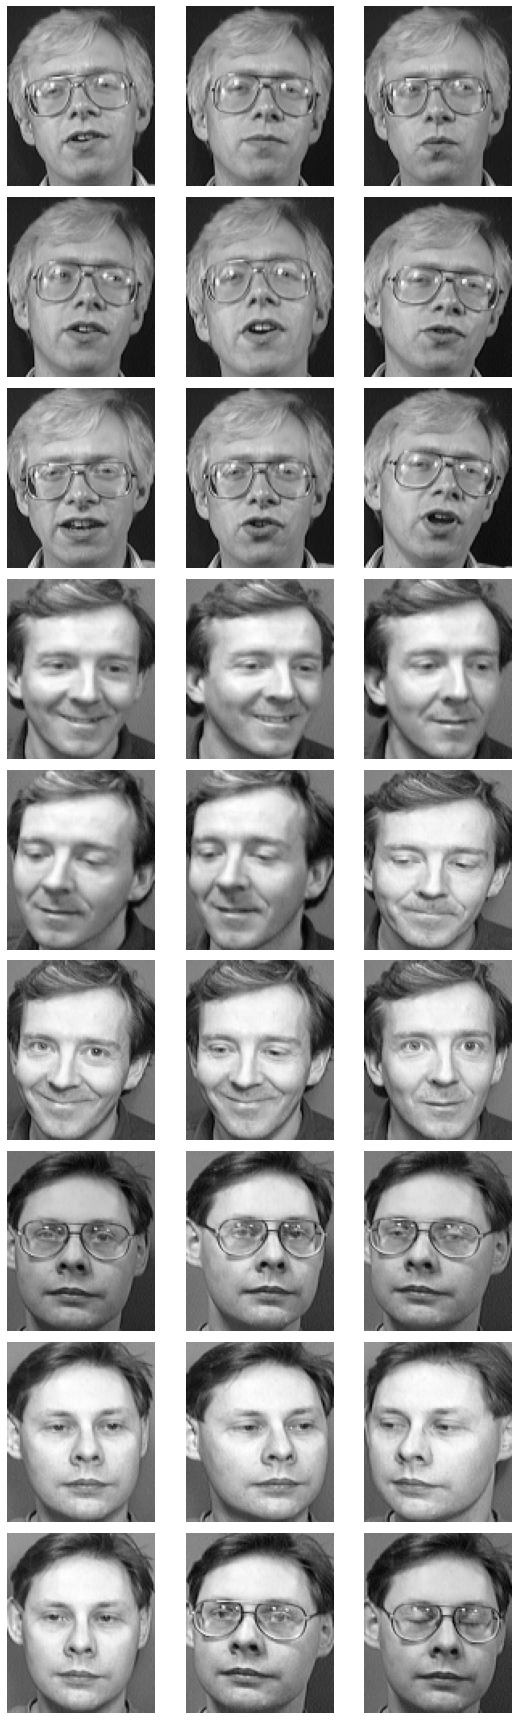

In [28]:
# You can specify you directory here, please, change the string below:
path = np.array(['./ATT dataset/s2/', './ATT dataset/s3/', './ATT dataset/s4/'])

###number of images per the training set
M = 9

###parameters for image normalization
um = 100
ustd = 80

###Reading and showing images

# loading only one image to get the dimensions
# you can use images .jpg and .ng as well
img = imread(path[0] + '1.pgm', as_gray=True)

# get the number of rows (irow) and columns (icol). 
# these values must to be the same for all images
irow, icol = img.shape

# allocation of vector that will have all images
S = np.zeros((irow*icol, M*len(path))) # img matrix

plt.figure(figsize=(8,24))
###loop through the 3 different sets
for j in range(0,len(path)):
    
    ###loop through each set
    for i in range(1,M+1):
        img = imread(path[j] + '{}.pgm'.format(i), as_gray=True)

        plt.subplot(9,3,i+(9*j))
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        # reshape(img',irow*icol,1); 
        # creates a (N1*N2)x1 vector
        temp = np.reshape(img, (irow*icol,1))
        S[:,(i-1)+(9*j)] = temp[:,0] 
# after finishing the sequence, S is a N1*N2xM matrix 

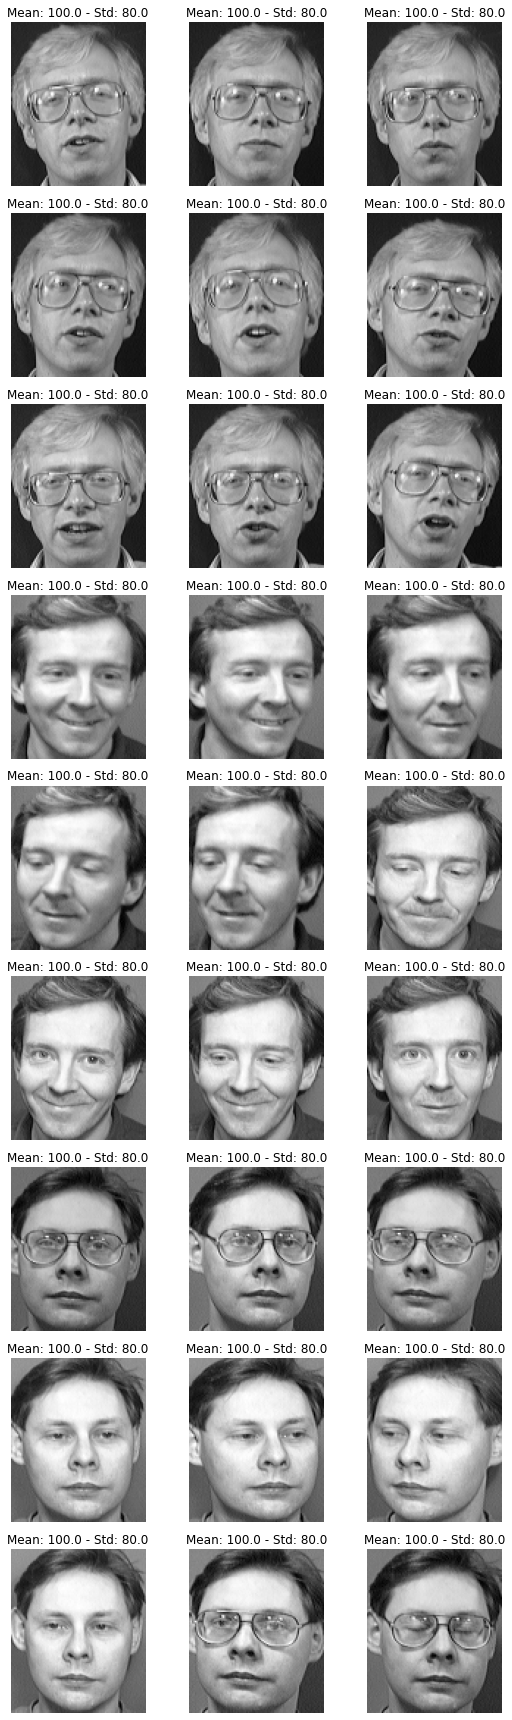

In [29]:
### normalizing images

# looping over all the loaded images in S to normalize
for i in range(S.shape[1]):
    temp = S[:,i]
    m = np.mean(temp)
    st = np.std(temp)
    # calculation where are defined the new pixels intensities
    S[:,i] = (temp - m) * ustd / st + um
    
### showing normalized images
plt.figure(figsize=(8,8*len(path)))
for i in range(M*len(path)):
    img = np.reshape(S[:,i], (irow, icol))
    
    plt.subplot(3*len(path),3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Mean: %.1f - Std: %.1f' % (np.mean(img), np.std(img)))


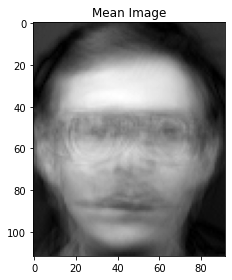

In [30]:
##### DO WE NEED THIS
### showing mean image

# calculates the mean of each row instead of each column
m = np.mean(S, axis=1)
# converts to unsigned 8-bit integer. Values range from 0 to 255
m = np.uint8(np.abs(m)).reshape(-1,1) 

img = np.reshape(m, (irow, icol))
plt.imshow(img, cmap='gray')
plt.title('Mean Image');

In [31]:
### creating covariance matrix

dbx = S.copy()
A = dbx.T
L = np.matmul(A, A.T)

# vv is the eigenvector for L
# dd is the eigenvalue for  L = dbx.T*dbx
dd, vv = la.eig(L)

### sort and eliminate zero eigenvalues
v = np.zeros(vv.shape)
d = np.zeros(dd.shape)

for i in range(vv.shape[1]):
    if (dd[i] > 1e-4):
        v[:,i] = vv[:,i]
        d[i] = dd[i]
        
# sort d in ascending order
index = np.argsort(d)
B = d[index]
ind = np.zeros(index.shape).astype(int)
dtemp = np.zeros(index.shape)
vtemp = np.zeros(v.shape)

idx_len = len(index)
for i in range(idx_len):
    dtemp[i] = B[idx_len-1-i]
    ind[i] = idx_len-1-index[i]
    vtemp[:,ind[i]] = v[:,i]

d = dtemp
v = vtemp


### normalize eigenvectors
for i in range(v.shape[1]):
    kk = v[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    v[:,i] = v[:,i] / temp
    
# Eigenvectors of C matrix
u = np.zeros(dbx.shape)
for i in range(v.shape[1]):
    temp = np.sqrt(d[i])
    u[:,i] = np.matmul(dbx, v[:,i]) / temp
    
for i in range(u.shape[1]):
    kk = u[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    u[:,i] = u[:,i] / temp

<ipython-input-31-7bcba3fe01e4>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i] = dd[i]


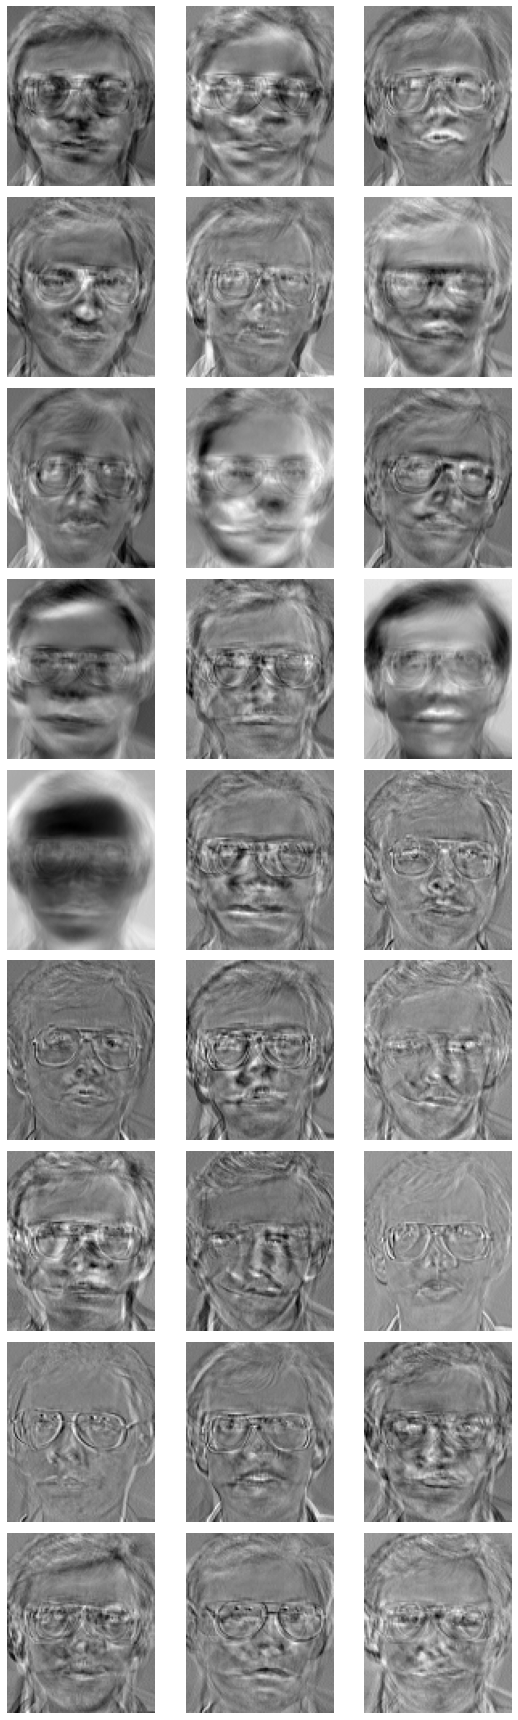

In [32]:
### showing eigenface

plt.figure(figsize=(8,8*len(path)))
for i in range(M*len(path)):
    img = np.reshape(u[:,i], (irow, icol))
    
    plt.subplot(3*len(path),3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

In [33]:
### finding weight of each image

omega = np.zeros((M*len(path),M*len(path)))
WW = np.zeros((M*len(path),1))

for h in range(dbx.shape[1]):
    for i in range(u.shape[1]):
        t = u[:,i].T
        WeightOfImage = np.dot(t, dbx[:,h].T)
        WW[i] = WeightOfImage
    omega[:,h] = WW[:,0]

#### Eucledian Calculation

In [34]:
# using the last image of subject #2
path = './ATT dataset/s3/'
InputImage = imread(path + '10.pgm', as_gray=True)

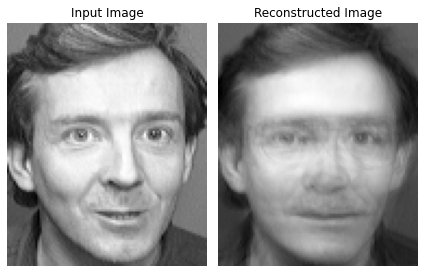

In [35]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M*3,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

In [36]:
eSameSubject = np.zeros((M*3,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eSameSubject[i] = mag

# max/min Euclidean distance
MaximumValue = np.max(eSameSubject) 
MinimumValue = np.min(eSameSubject)


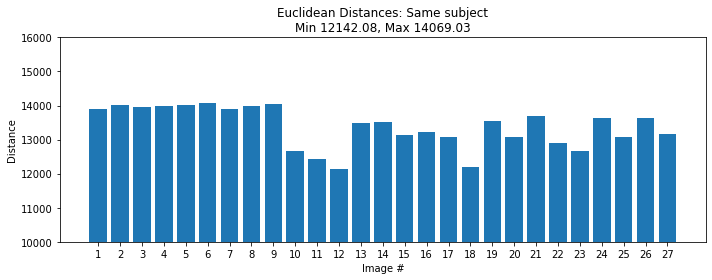

In [37]:
labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9','10',
         '11', '12', '13', '14', '15', '16', '17', '18', '19','20',
        '21', '22', '23', '24', '25', '26', '27')

plt.figure(figsize=(10,4))
plt.bar(np.arange(len(eSameSubject)), eSameSubject.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Same subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

In [38]:
# using the first face ('1.pgm') from subject 20
path = './ATT dataset/s6/'
InputImage = imread(path + '1.pgm', as_gray=True)

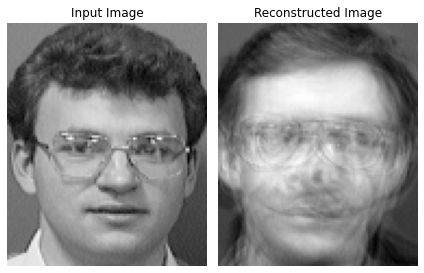

In [39]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M*3,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

In [40]:
eDiffSubject = np.zeros((M*3,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eDiffSubject[i] = mag
    
# max/min Eucledian distance
MaximumValue = np.max(eDiffSubject) 
MinimumValue = np.min(eDiffSubject) 


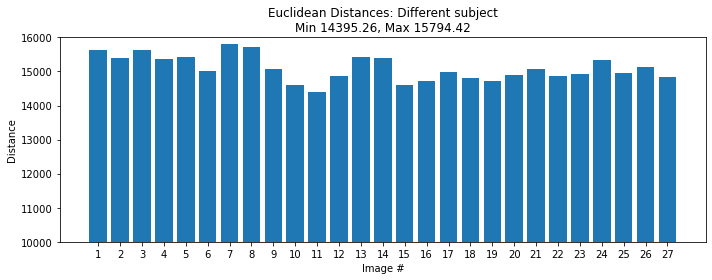

In [41]:
labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9','10',
         '11', '12', '13', '14', '15', '16', '17', '18', '19','20',
        '21', '22', '23', '24', '25', '26', '27')

plt.figure(figsize=(10,4))
plt.bar(np.arange(len(eDiffSubject)), eDiffSubject.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Different subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

In [42]:
path = './'
InputImage = imread(path + 'CalgaryTower.jpg', as_gray=True)

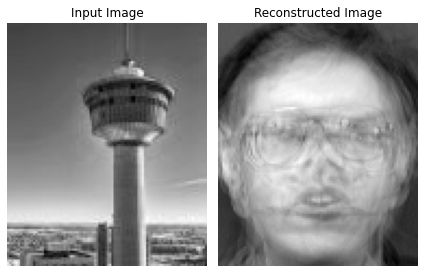

In [43]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M*3,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

In [44]:
eTower = np.zeros((M*3,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eTower[i] = mag
    
# max/min Eucledian distance
MaximumValue = np.max(eTower) 
MinimumValue = np.min(eTower) 

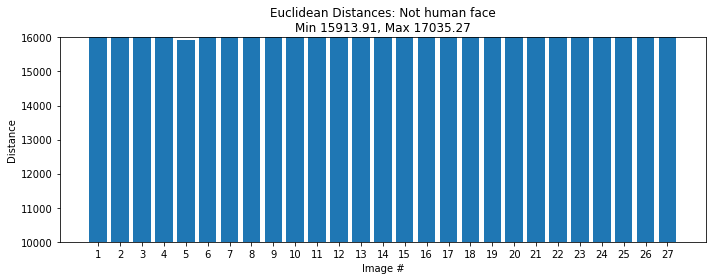

In [45]:
labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9','10',
         '11', '12', '13', '14', '15', '16', '17', '18', '19','20',
        '21', '22', '23', '24', '25', '26', '27')

plt.figure(figsize=(10,4))
plt.bar(np.arange(len(eTower)), eTower.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Not human face\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

#### Discussion of Example 1
In this setup we used three examples from the AT&T database to create a trained model. Each picture was normalized on size, tone, and grayscale. We used these to create eigenfaces, which would would be the standard for which the probe pictures would be tested against. Then 3 types of probes were assesed. One which belonged to the set, on which was a face but was not in the set, and one which was not even a face. The eucladian distances from these and the set were used as the threshold measures for determining future probe results.

### Exercise 2

In [46]:
# Set Threshold Values 
threshold1 = 14000
threshold2 = 16000 # has been changed

#uncomment one to see if image is in the database or not
#distances = eSameSubject
distances = eDiffSubject
#distances = eTower


mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Image is in the database')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face')

Image is a face but not in the database


In [47]:
# Set Threshold Values 
threshold1 = 14000
threshold2 = 16000 # has been changed

#uncomment one to see if image is in the database or not
#distances = eSameSubject
distances = eDiffSubject
#distances = eTower


mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Image is in the database')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face')

Image is a face but not in the database


In [48]:
# Set Threshold Values 
threshold1 = 14000
threshold2 = 16000 # has been changed

#uncomment one to see if image is in the database or not
#distances = eSameSubject
#distances = eDiffSubject
distances = eTower


mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Image is in the database')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face')

Image is not a face


#### Discussion of Example 2

For this example we used manually input for the threshold values, which were roughly based on the results from the three probe cases. Then we set the prepared probe results to three categories as described above. Less than the first threshold would be a face in the set, inbetween the two thresholds would be a face which was not in the database, and greater than the second threshold would be an example which was not a face. The probes were prepared in the same fashion as the set of faces.

### Exercise 3

In [49]:
# Set Threshold Values 
#threshold1 = (np.max(eSameSubject) + np.min(eDiffSubject))/2
#threshold2 = (np.max(eDiffSubject) + np.min(eTower))/2
threshold1 = np.max(eSameSubject)
threshold2 = np.max(eDiffSubject)
print("threshold1:", threshold1)
print("threshold2:", threshold2)
#uncomment one to see if image is in the database or not
distances = eSameSubject
#distances = eDiffSubject
#distances = eTower


mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Image is in the database')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face')

threshold1: 14069.027796379589
threshold2: 15794.4153998932
Image is in the database


In [50]:
# Set Threshold Values 
#threshold1 = (np.max(eSameSubject) + np.min(eDiffSubject))/2
#threshold2 = (np.max(eDiffSubject) + np.min(eTower))/2
threshold1 = np.max(eSameSubject)
threshold2 = np.max(eDiffSubject)

print("threshold1:", threshold1)
print("threshold2:", threshold2)
#uncomment one to see if image is in the database or not
#distances = eSameSubject
distances = eDiffSubject
#distances = eTower


mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Image is in the database')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face')

threshold1: 14069.027796379589
threshold2: 15794.4153998932
Image is a face but not in the database


In [51]:
# Set Threshold Values 
threshold1 = np.max(eSameSubject)
threshold2 = np.max(eDiffSubject)

print("threshold1:", threshold1)
print("threshold2:", threshold2)
#uncomment one to see if image is in the database or not
#distances = eSameSubject
#distances = eDiffSubject
distances = eTower


mean_of_distances = np.mean(distances);
if (mean_of_distances <= threshold1):
    print('Image is in the database')
elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
    print('Image is a face but not in the database')
elif (mean_of_distances > threshold2):
    print('Image is not a face')

threshold1: 14069.027796379589
threshold2: 15794.4153998932
Image is not a face


#### Discussion of Example 3

In this continuation we set the thresholds to max values of the match face and non-match face. This was in an attempt to get closer to the actual thresholds for the classification. This led to very similar result, however also introduced a few false positives. We would suggest a little further investigation to a correction that could be applied to the calculation of the thresholds. It could possibly be off, because of a right/left skew to the distribution of the eucladian distances. We could possibly look at involving an algorithm based more on a mean and standard deviations off of the mean.

### Conclusion
In this lab we have seen how to pre-process some image data, train a system based on eucladian distance, run probe tests, and then classify on the results. Overall, this has been very informative on a basic system of facial recognition and how well even this simple system can be at predicting not only a match but also which category the probe image fits in. However, it has also pointed out that there is always a more accurate way to classify and that different algorithms will lead to different results. We understand that there are many other ways to train, test, and improve our system.